In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm


In [2]:
train_df = pd.read_csv("train.csv")
stores_df = pd.read_csv("stores.csv")
features_df = pd.read_csv("features.csv")
test_df=pd.read_csv("test.csv")

In [3]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [6]:
features_df['Store'] = features_df['Store'].astype(str)
train_df['Store'] = train_df['Store'].astype(str)
stores_df['Store'] = stores_df['Store'].astype(str)

features_df['Store'] = features_df['Store'].str.strip()
train_df['Store'] = train_df['Store'].str.strip()
stores_df['Store'] = stores_df['Store'].str.strip()
train_df['Date'] = pd.to_datetime(train_df['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])
train_df['Day'] = train_df['Date'].dt.day
train_df['Month'] = train_df['Date'].dt.month
train_df['year'] = train_df['Date'].dt.year

features_df['CPI'].interpolate(method='linear', inplace=True)
features_df['Unemployment'].interpolate(method='linear', inplace=True)


In [7]:
merged_df = pd.merge(train_df, stores_df, on='Store')
store_dept_table = pd.pivot_table(merged_df, index='Store', columns='Dept',values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
10,39925.138951,109795.291469,32086.181469,48579.826364,58373.460280,10556.550769,58964.715664,86739.846643,64436.722517,48108.063497,...,14291.869790,12703.554406,50450.731958,1420.418462,393.833168,73344.654685,11079.676643,5323.506503,198.179091,NaN
11,18860.911958,57114.326224,17628.778671,28837.744545,36663.363916,5925.281678,34844.108462,34415.449580,19056.162168,23449.992727,...,48995.984196,42030.370699,77392.741608,32623.853706,37474.038531,77487.279091,21685.298811,16596.197552,9570.351469,520.938125
12,17330.087622,74494.846224,17535.251678,26673.788182,27756.204615,6741.174895,34242.449161,42229.665035,19553.030490,17975.211119,...,11060.175455,6779.841469,24682.599161,562.897203,355.264000,43405.853357,6.441176,2394.894755,747.609860,29.880000
13,47020.455455,76339.960000,26116.623706,42563.275455,56786.934755,7886.826993,59896.738601,36238.867972,41236.445175,29431.879231,...,115592.108042,81272.990979,162034.099301,50024.937203,75522.874406,136844.834056,9165.079930,27556.759231,14980.825385,732.604651
14,30611.783357,77704.857972,19418.273986,52936.323287,33468.325035,7016.829790,53256.150280,53425.359860,22025.603497,20165.667133,...,107174.743986,91406.434615,182527.956014,62088.622937,64541.165664,144446.932517,5.193846,25684.497762,17768.013706,635.556047
15,13845.747832,26317.410769,10470.811958,13082.172448,16465.706993,4244.143776,22267.220070,20416.967273,15954.692937,11524.856294,...,5345.240420,3414.740909,18262.376853,422.878252,272.906250,27291.017133,2784.158881,2071.211888,273.504884,29.880000
16,11352.479371,23549.144965,7635.427273,14748.078112,13494.538671,5146.038951,11544.310140,14676.778322,28990.377343,12681.776643,...,6922.744685,3331.204965,20446.967832,997.032281,673.280928,27385.769231,126.934126,2116.696993,42.618571,59.760000
17,22801.609161,42231.844406,19278.955035,23961.357273,27082.325594,5944.435245,19474.770559,20110.270839,27293.658042,14165.000000,...,31293.306224,12033.678951,53043.348741,3646.955664,855.782273,50614.958462,819.416458,7798.283427,169.379120,2.290000


In [11]:
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Day,Month,year,Type,Size
0,1,1,2010-02-05,24924.50,False,5,2,2010,A,151315
1,1,1,2010-02-12,46039.49,True,12,2,2010,A,151315
2,1,1,2010-02-19,41595.55,False,19,2,2010,A,151315
3,1,1,2010-02-26,19403.54,False,26,2,2010,A,151315
4,1,1,2010-03-05,21827.90,False,5,3,2010,A,151315


In [8]:
merged_df = merged_df.loc[merged_df['Weekly_Sales'] > 0]

In [9]:
full_df = pd.merge(merged_df, features_df, on=['Store', 'Date'])

In [10]:
fillnan = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
full_df[fillnan] = full_df[fillnan].fillna(0)

In [11]:
full_df.loc[full_df['Weekly_Sales'] == 0.01, 'Weekly_Sales'] = full_df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform('median')

In [16]:
train_df['Date'].head()

,Date
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05


In [12]:
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%Y-%m-%d', dayfirst=True)


In [13]:
full_df.drop(columns=["IsHoliday_y"], inplace=True)
full_df.rename(columns={"IsHoliday_x": "IsHoliday"}, inplace=True)
full_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Day,Month,year,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,5,2,2010,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,12,2,2010,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,19,2,2010,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,26,2,2010,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,5,3,2010,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


In [14]:
full_df['Date'] = pd.to_datetime(full_df['Date'], dayfirst=True)
full_df.set_index('Date', inplace=True)
full_df['DayOfWeek'] = full_df.index.dayofweek
full_df['WeekOfYear'] = full_df.index.isocalendar().week


In [15]:
full_df["Weekly_Sales"].describe()

,Weekly_Sales
count,420212.000000
mean,16033.129328
std,22729.482785
min,0.020000
25%,2120.140000
50%,7661.700000
75%,20271.265000
max,693099.360000


In [16]:
df_encoded_1 = full_df.copy()

In [22]:
df_encoded_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138743 entries, 2010-02-05 to 2012-03-09
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         138743 non-null  int64  
 1   Dept          138743 non-null  int64  
 2   Weekly_Sales  138743 non-null  float64
 3   IsHoliday     138743 non-null  bool   
 4   Day           138743 non-null  int32  
 5   Month         138743 non-null  int32  
 6   year          138743 non-null  int32  
 7   Type          138743 non-null  object 
 8   Size          138743 non-null  int64  
 9   Temperature   138743 non-null  float64
 10  Fuel_Price    138743 non-null  float64
 11  MarkDown1     138743 non-null  float64
 12  MarkDown2     138743 non-null  float64
 13  MarkDown3     138743 non-null  float64
 14  MarkDown4     138743 non-null  float64
 15  MarkDown5     138743 non-null  float64
 16  CPI           138743 non-null  float64
 17  Unemployment  138743 non-null  f

In [17]:
df_encoded_1["WeekOfYear"].astype(int)

,WeekOfYear
Date,
2010-02-05,5
2010-02-12,6
2010-02-19,7
2010-02-26,8
2010-03-05,9
...,...
2012-09-28,39
2012-10-05,40
2012-10-12,41


In [18]:
type_group = {'A':1, 'B': 2, 'C': 3}
df_encoded_1['Type'] = df_encoded_1['Type'].replace(type_group)
df_encoded_1.head()

,Store,Dept,Weekly_Sales,IsHoliday,Day,Month,year,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,DayOfWeek,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,5,2,2010,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,5
2010-02-12,1,1,46039.49,True,12,2,2010,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,4,6
2010-02-19,1,1,41595.55,False,19,2,2010,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,4,7
2010-02-26,1,1,19403.54,False,26,2,2010,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,4,8
2010-03-05,1,1,21827.90,False,5,3,2010,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,4,9


In [19]:
IsHoliday = {'True':1, 'False': 0}
df_encoded_1['IsHoliday'] = df_encoded_1['IsHoliday'].replace(IsHoliday)
df_encoded_1.head()

,Store,Dept,Weekly_Sales,IsHoliday,Day,Month,year,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,DayOfWeek,WeekOfYear
Date,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,5,2,2010,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,5
2010-02-12,1,1,46039.49,True,12,2,2010,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,4,6
2010-02-19,1,1,41595.55,False,19,2,2010,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,4,7
2010-02-26,1,1,19403.54,False,26,2,2010,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,4,8
2010-03-05,1,1,21827.90,False,5,3,2010,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,4,9


In [26]:
X = df_encoded_1.drop('Weekly_Sales', axis=1)
y = df_encoded_1['Weekly_Sales']
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

KeyboardInterrupt: 

In [20]:
df_train = df_encoded_1.copy()

In [28]:
"""
drop_col = ['DayOfWeek','year','MarkDown2','IsHoliday','MarkDown1','MarkDown4','MarkDown5','MarkDown1']

df_train.drop(drop_col, axis=1, inplace=True)\
"""

In [21]:
X = df_train.drop(columns=['Weekly_Sales'])
y = df_train['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=50, random_state=42 ,max_depth=15,min_samples_leaf=5,min_samples_split=5)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=50, random_state=42)

In [31]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse_train  = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(rmse_train)
rmse_test  = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(rmse_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test R2: {r2_test:.4f}")


Train RMSE: 4044.5487
Train R2: 0.9770
Test RMSE: 5132.1252
Test MAE: 1930.7695
Test R2: 0.9618


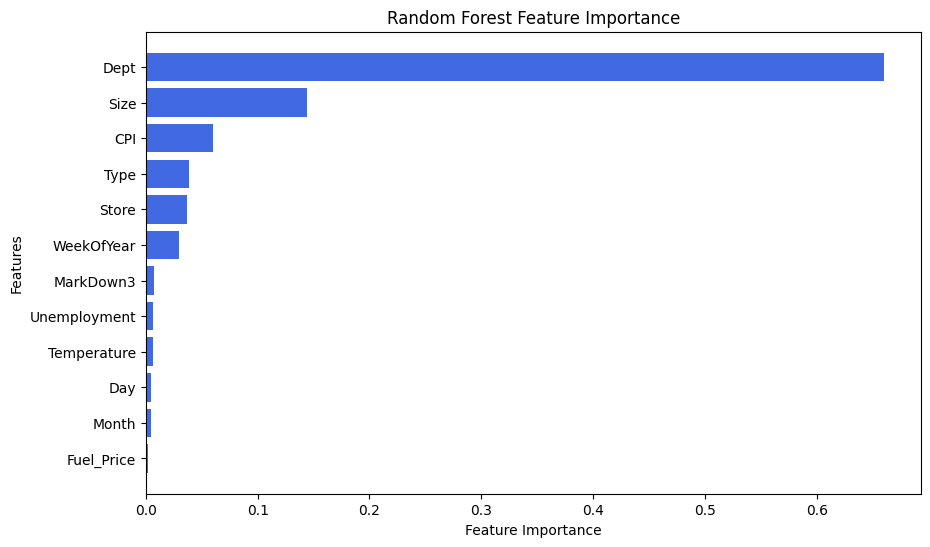

In [33]:
importances = rf_model.feature_importances_
feature_names = X_train.columns

sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx], color='royalblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()


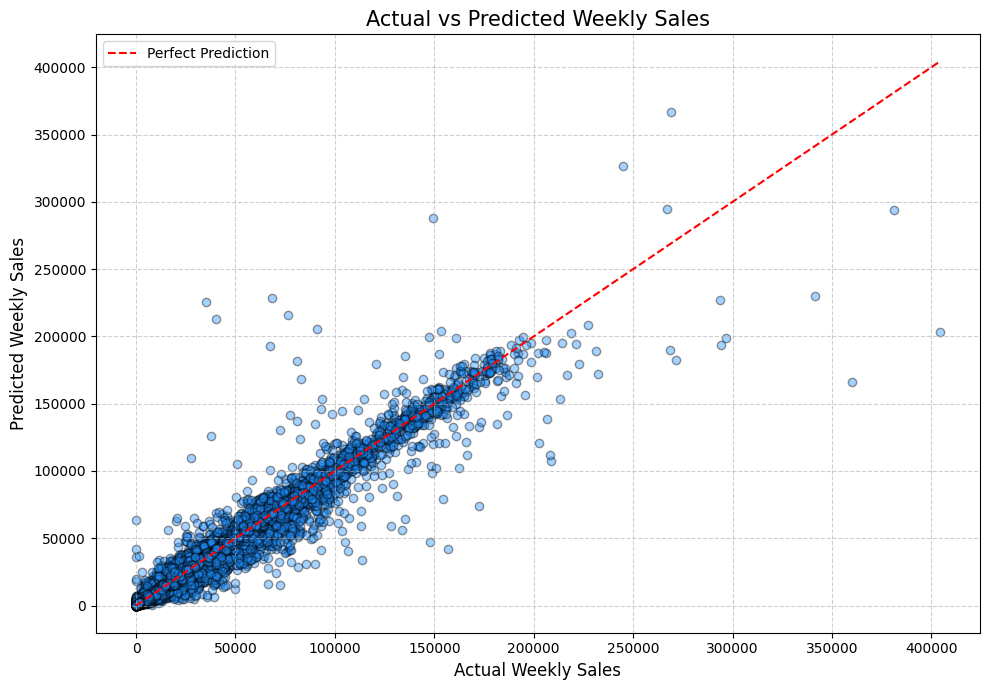

In [46]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_test_pred, alpha=0.4, color='dodgerblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Weekly Sales', fontsize=12)
plt.ylabel('Predicted Weekly Sales', fontsize=12)
plt.title('Actual vs Predicted Weekly Sales', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


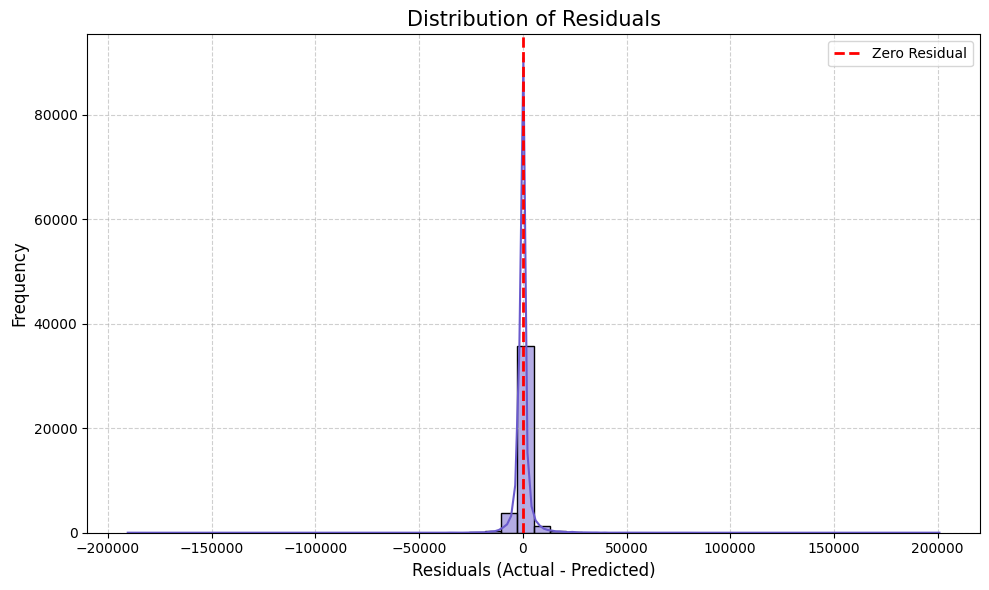

In [47]:
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='slateblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residuals', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


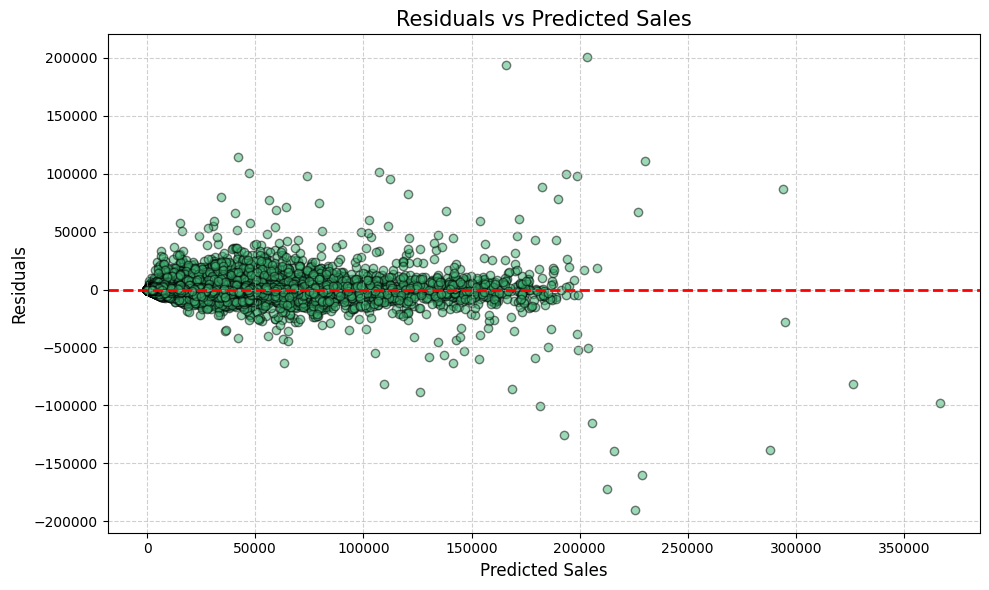

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5, color='mediumseagreen', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Sales', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residuals vs Predicted Sales', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


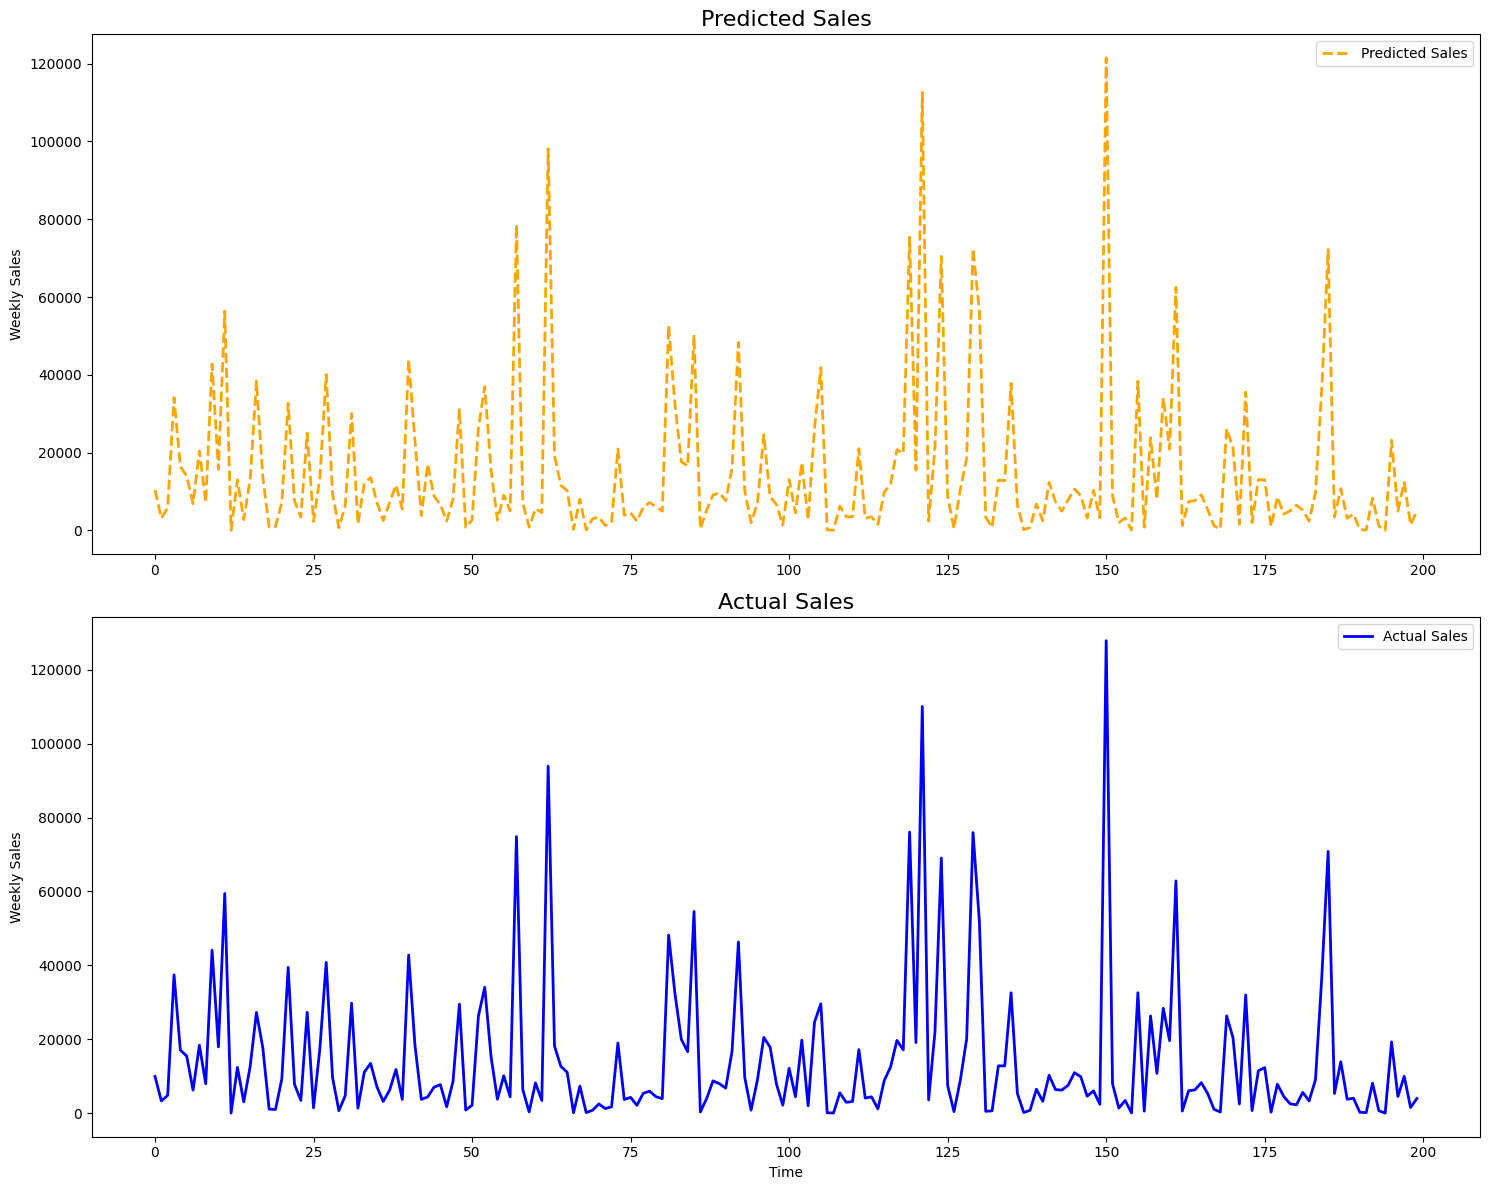

In [45]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_actual, y_predicted, n=100, actual_label="Actual Sales", predicted_label="Predicted Sales",
                              actual_color='blue', predicted_color='orange', predicted_linestyle='dashed',
                              figsize=(15, 12), title_actual="Actual Sales", title_predicted="Predicted Sales"):


      # Subset the data
      y_actual_subset = y_actual[:n]
      y_predicted_subset = y_predicted[:n]

      # Create subplots
      fig, ax = plt.subplots(2, 1, figsize=figsize)

      # Predicted values
      ax[0].plot(y_predicted_subset, label=predicted_label, linewidth=2.0, color=predicted_color, linestyle=predicted_linestyle)
      ax[0].set_title(title_predicted, fontsize=16)
      ax[0].set_ylabel('Weekly Sales')
      ax[0].legend(loc="best")

      # Actual values
      ax[1].plot(y_actual_subset, label=actual_label, linewidth=2.0, color=actual_color)
      ax[1].set_title(title_actual, fontsize=16)
      ax[1].set_xlabel('Time')
      ax[1].set_ylabel('Weekly Sales')
      ax[1].legend(loc="best")

      # Layout
      plt.tight_layout()
      plt.show()
plot_actual_vs_predicted(y_test.values, y_test_pred, n=200)


In [158]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("The series is non-stationary and needs differencing.")
    else:
        print("The series is stationary.")

adf_test(df_encoded_1['Weekly_Sales'])


ADF Statistic: -17.978594878919875
p-value: 2.7798201946350238e-30
The series is stationary.


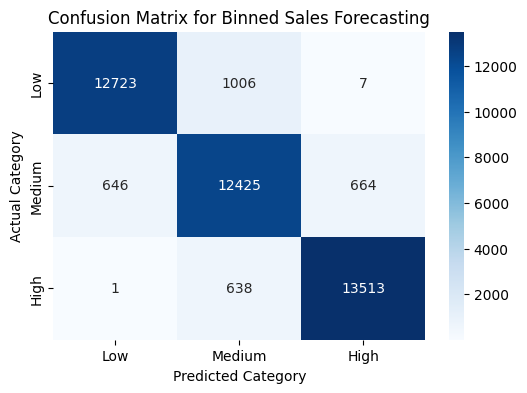

In [38]:
bins = [-np.inf, y_test.quantile(0.33), y_test.quantile(0.66), np.inf]
labels = ["Low", "Medium", "High"]

y_val_cat = pd.cut(y_test, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_test_pred, bins=bins, labels=labels)

conf_matrix = confusion_matrix(y_val_cat, y_pred_cat, labels=labels)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Category")
plt.ylabel("Actual Category")
plt.title("Confusion Matrix for Binned Sales Forecasting")
plt.show()


#Forecasting

In [43]:
# ---------------------------------------------------
#  Weekly Aggregation of Sales Data
# ---------------------------------------------------
weekly_sales = df_encoded_1['Weekly_Sales'].resample('W').sum().reset_index()
weekly_sales.set_index('Date', inplace=True)

# ---------------------------------------------------
# (last 52 weeks as test set)
# ---------------------------------------------------
train_data = weekly_sales.iloc[:-52]
test_data = weekly_sales.iloc[-52:]



In [51]:
# ---------------------------------------------------
# SARIMA Parameter Grid Search
# ---------------------------------------------------
best_model = None
best_aic = np.inf
optimal_order = ()
optimal_seasonal_order = ()

p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
seasonal_period = 52  # Weekly seasonality

print("Starting SARIMA Grid Search...\n")
for i in tqdm(p, desc='p'):
    for j in d:
        for k in q:
            for sp in P:
                for sd in D:
                    for sq in Q:
                        try:
                            model = SARIMAX(train_data,
                                            order=(i, j, k),
                                            seasonal_order=(sp, sd, sq, seasonal_period),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                            fitted_model = model.fit(disp=False)
                            aic_score = fitted_model.aic

                            if aic_score < best_aic:
                                best_aic = aic_score
                                optimal_order = (i, j, k)
                                optimal_seasonal_order = (sp, sd, sq, seasonal_period)
                                best_model = fitted_model
                        except Exception as err:
                            print(f"[!] Failed SARIMA({i},{j},{k})x({sp},{sd},{sq},{seasonal_period}): {err}")

print("Optimal SARIMA Order:", optimal_order)
print(" Optimal Seasonal Order:", optimal_seasonal_order)
print(f"Lowest AIC Achieved: {best_aic:.2f}")




Starting SARIMA Grid Search...



p: 100%|██████████| 3/3 [03:29<00:00, 69.96s/it]

Optimal SARIMA Order: (0, 0, 0)
 Optimal Seasonal Order: (0, 1, 1, 52)
Lowest AIC Achieved: 4.00


In [45]:
# ---------------------------------------------------
# Walk-Forward Validation
# ---------------------------------------------------
print("Performing Walk-Forward Validation...\n")
predictions = []

for step in range(len(test_data)):
    training_slice = weekly_sales.iloc[:-(52 - step)]
    try:
        model = SARIMAX(training_slice,
                        order=optimal_order,
                        seasonal_order=optimal_seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=1)
        predictions.append(forecast.values[0])
    except Exception as e:
        predictions.append(np.nan)
        print(f"Forecast error at step {step}: {e}")


Performing Walk-Forward Validation...



In [46]:
print("Model Evaluation Metrics:\n")
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mape = np.mean(np.abs((test_data.values - predictions) / test_data.values)) * 100
accuracy = 100 - mape

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


Model Evaluation Metrics:

MAE  : 1597506.98
RMSE : 2128312.27
MAPE : 10.14%
Accuracy: 89.86%


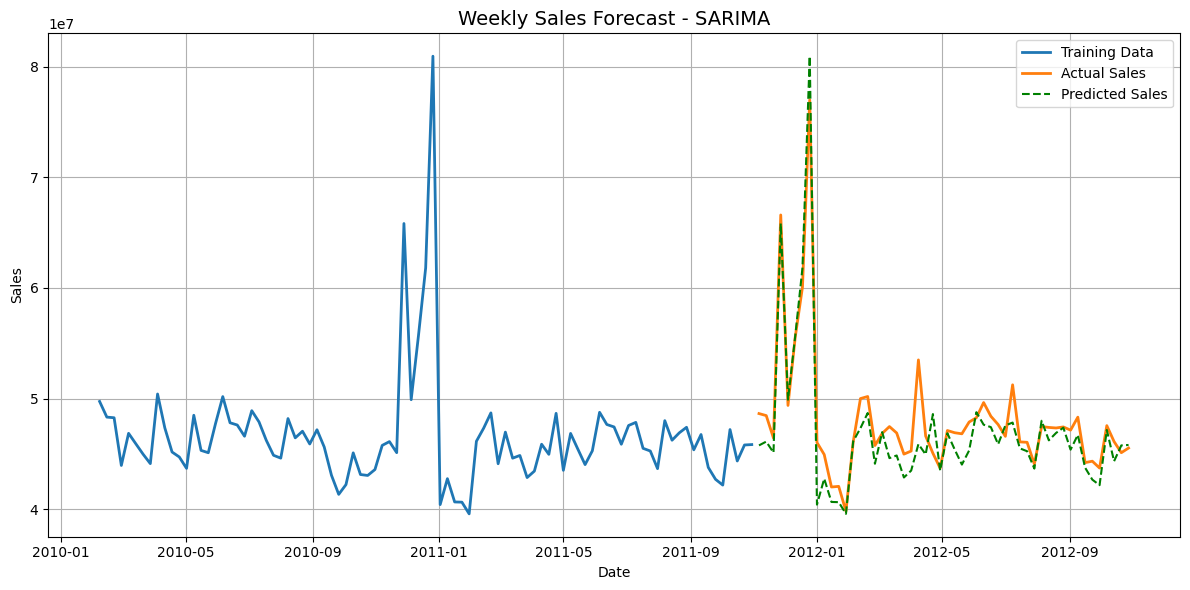

In [49]:

# ---------------------------------------------------
# Forecasting Visualization
# ---------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', linewidth=2)
plt.plot(test_data.index, test_data, label='Actual Sales', linewidth=2)
plt.plot(test_data.index, predictions, label='Predicted Sales', linestyle='--', color='green')
plt.title("Weekly Sales Forecast - SARIMA", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



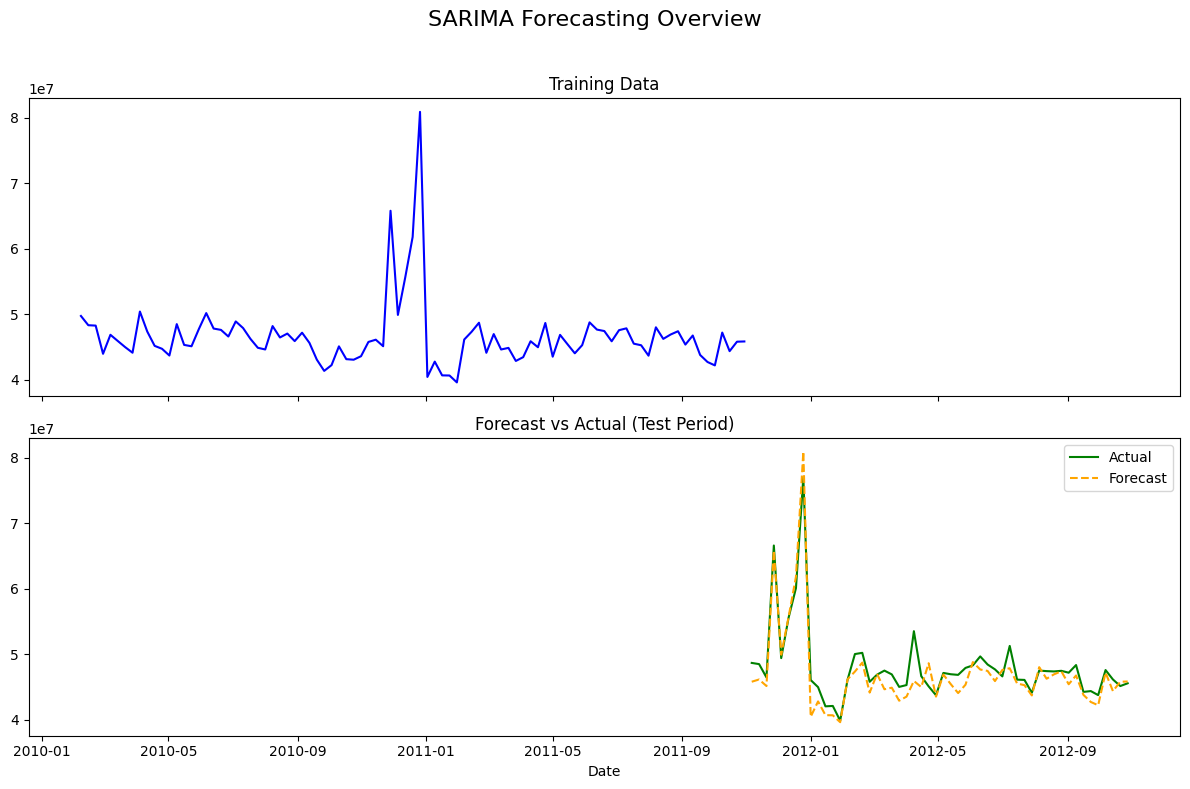

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(train_data.index, train_data, color='blue')
axs[0].set_title("Training Data")

axs[1].plot(test_data.index, test_data, label='Actual', color='green')
axs[1].plot(test_data.index, predictions, label='Forecast', color='orange', linestyle='--')
axs[1].set_title("Forecast vs Actual (Test Period)")
axs[1].legend()

plt.suptitle("SARIMA Forecasting Overview", fontsize=16)
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()